# Study to Improve Number of Engagements of Social Media Posts: Fresh Tape Media

## Background

Fresh Tape Media (FTM) is a company that creates made-for-social video content for sports business brands. Currently, they are ‚Äúgoing with their gut‚Äù when it comes to the type of content that create for a client, in hopes that the video will get a lot of views/engagements. Ultimately, I will be answering the question *What type of content sentiment generates the most favorites/engagements on Twitter?*

The value of the solution below is that FTM will be able to create content that results in the words in the hashtags/comments that correlate with the most viewership (and avoid words that negatively impact viewership). This will help drive their business because FTM will be able to make data-driven recommendations to their clients when determining the content sentiment of their material.


#### import libraries
#### twitter api credentials

In [3]:
import pandas as pd
import numpy as np
import tweepy
import twitter
import time


In [4]:
consumer_key = "X"
consumer_secret = "X"
access_token = "X"
access_token_secret = "X"

### credentials/authorization for tweepy (standard API)

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Access to Data: 

Through FTM's admin access, I was able to pull a spreadsheet of all of the FTM content that was posted to Twitter (by different professional athletes, sports leagues, sports teams, and broadcasters) within the last seven days. For each post, the spreadsheet contained the url, the number of likes/favorites, the account that posted, the number of shares/re-tweets, and the number of comments.

I used that spreadsheet to isolate the tweet ID from the URL, which I used to scrape the Standard Twitter API (which only has seven days of storage) to pull all of the replies to each tweet. From this, I had a spreadsheet of all of the replies to FTM Twitter content in the past seven days.

I also wanted to bring in high-performing and low-performing (based on number of likes) content that was NOT produced by FTM. In order to do, I scraped the Twitter API for all tweets in the last seven days from the same accounts that posted FTM content. When doing so, I also scraped the number of followers each account had. Considering the number of followers was important so that I could normalize the predictive value. For example, if one account has 78,000 followers and another has 15,000,000 followers, one would assume that the latter account would always have significantly more likes than the former. Instead of seeking to predict the number of likes/favorites, I predicted the percentage of likes (simply, the ratio of likes to the number of followers for a given account). 

Once I had that spreadsheet of non-FTM tweets by the same accounts, I limited the number of tweets to the top-two and bottom-two performers and went back to the Twitter API to scrape replies - the same way that I scraped the FTM replies. 

Finally, I concatenated both dataframes and had one large dataframe of all of the replies to both FTM and non-FTM content posted on Twitter in the last seven days.

### loading FTM dataframe

In [6]:
FTM_df1 = pd.read_excel("FTMTweets3.xlsx")
FTM_df2 = pd.read_excel("FTMTweets.xlsx")
FTM_df = pd.concat([FTM_df1, FTM_df2])

In [7]:
FTM_df.head()

ID    Network                                        URL         Account  \
0  2008    Twitter  /NikolaVucevic/status/1098235335132303362   NikolaVucevic   
1  1994  Instagram                            /p/BuDEa2snJ8V/  marcelashoward   
2  1892    Twitter       /NBAKicks/status/1097544211656790017        NBAKicks   
3  1902  Instagram                            /p/BuB_G0tBEGl/        nbakicks   
4  1903  Instagram                            /p/BuB9pPtBT56/        nbakicks   

    Type  Views  Shares  Likes  Dislikes  Comments               Post date  \
0    NaN      0      10    193         0         8 2019-02-20 14:58:02.004   
1    GIF      0       0   6889         0        11 2019-02-19 03:16:43.000   
2  Video   2277      10     87         0         3 2019-02-18 17:11:45.997   
3  Video   9995       0   3603         0        21 2019-02-18 17:11:18.004   
4  Video   7033       0   2824         0         7 2019-02-18 16:58:42.997   

               Track date            Last updated  \
0 2019-02-20 17:11:24.000 2019-02-21 01:06:36.000   
1 2019-02-20 02:00:22.003 2019-02-21 01:19:39.000   
2 2019-02-18 20:17:40.004 2019-02-21 01:28:33.997   
3 2019-02-19 18:11:24.996 2019-02-21 01:18:43.004   
4 2019-02-19 18:11:32.997 2019-02-21 01:17:45.004   

                                        Post caption       Thumbnail  \
0       üî•üî•üî•üî• @nikebasketball https://t.co/CTgFISbgDy             NaN   
1  @NBA All Star Weekend Was One For The Books! T...  908d4b4efd.jpg   
2  üèÄüåüüëü\n\n@JoelEmbiid x #NBAAllStar x #NBAKicks h...  114993e089.jpg   
3              @joelembiid x #NBAAllStar x #NBAKicks  dd79c23cf7.jpg   
4             #NikolaJokic x #NBAAllStar x #NBAKicks  a392e1ddb0.jpg   

   Event tag  Partner tag  Creator tag  Filetype tag  
0        NaN          NaN          NaN           NaN  
1        NaN          NaN          NaN           NaN  
2        NaN          NaN          NaN           NaN  
3        NaN          NaN          NaN           NaN  
4        NaN          NaN          NaN           NaN

In [8]:
FTM_df.shape

(318, 19)

In [9]:
FTM_df = FTM_df[FTM_df["Network"] == "Twitter"]

In [10]:
FTM_df.shape

(107, 19)

In [11]:
def strip_ID(url):       
    return url[-19:]

In [12]:
FTM_df["Tweet_ID"] = FTM_df["URL"].apply(strip_ID)

In [13]:
Followersdf = pd.read_csv("Twitter_Followers - Sheet1.csv")

In [14]:
Followersdf.head()

Account  Followers Sports League
0  NikolaVucevic      72400           NBA
1       NBAKicks      17800           NBA
2         nascar    3320000        Nascar
3  twittersports   15300000           All
4        nuggets     852000           NBA

In [15]:
FTM_df["Account"] = FTM_df["Account"].str.lower()

In [16]:
Followersdf["Account"] = Followersdf["Account"].str.lower()

In [17]:
FTM_df.head()

ID  Network                                        URL        Account  \
0   2008  Twitter  /NikolaVucevic/status/1098235335132303362  nikolavucevic   
2   1892  Twitter       /NBAKicks/status/1097544211656790017       nbakicks   
5   1891  Twitter       /nbakicks/status/1097537733155786753       nbakicks   
8   1896  Twitter       /NBAKicks/status/1097532955533160448       nbakicks   
11  1898  Twitter       /NBAKicks/status/1097527079569108992       nbakicks   

     Type  Views  Shares  Likes  Dislikes  Comments               Post date  \
0     NaN      0      10    193         0         8 2019-02-20 14:58:02.004   
2   Video   2277      10     87         0         3 2019-02-18 17:11:45.997   
5   Video  60777     164   1582         0        21 2019-02-18 16:46:01.001   
8   Video  29546      95    916         0         7 2019-02-18 16:27:01.999   
11  Video   4954       9     67         0         3 2019-02-18 16:03:40.997   

                Track date            Last updated  \
0  2019-02-20 17:11:24.000 2019-02-21 01:06:36.000   
2  2019-02-18 20:17:40.004 2019-02-21 01:28:33.997   
5  2019-02-18 17:16:49.002 2019-02-21 01:00:08.004   
8  2019-02-18 20:18:25.001 2019-02-21 01:24:30.004   
11 2019-02-18 20:18:41.003 2019-02-21 01:22:30.003   

                                         Post caption       Thumbnail  \
0        üî•üî•üî•üî• @nikebasketball https://t.co/CTgFISbgDy             NaN   
2   üèÄüåüüëü\n\n@JoelEmbiid x #NBAAllStar x #NBAKicks h...  114993e089.jpg   
5   üèÄüåüüëü\n\n@KDTrey5 x #NBAAllStar x #NBAKicks http...  56a2cee4b9.jpg   
8   üèÄüåüüëü\n\n@stephencurry30 x #NBAAllStar x #NBAKic...  6f23431157.jpg   
11  üèÄüåüüëü\n\n@NikolaVucevic x #NBAAllStar x #NBAKick...  fe6ee111a6.jpg   

    Event tag  Partner tag  Creator tag  Filetype tag             Tweet_ID  
0         NaN          NaN          NaN           NaN  1098235335132303362  
2         NaN          NaN          NaN           NaN  1097544211656790017  
5         NaN          NaN          NaN           NaN  1097537733155786753  
8         NaN          NaN          NaN           NaN  1097532955533160448  
11        NaN          NaN          NaN           NaN  1097527079569108992

In [18]:
follower_list = []

for i in range(FTM_df.shape[0]):
    account = FTM_df["Account"].iloc[i]
    n = np.where(Followersdf["Account"] == account)
    follower_list.append(Followersdf.iloc[int(n[0]), 1])
    
    

In [19]:
FTM_df["Followers_Count"] = follower_list

In [20]:
accounts = list(FTM_df["Account"].unique())

In [21]:
FTM_df["Percent_Likes"] = FTM_df["Likes"] / FTM_df["Followers_Count"]

In [22]:
FTM_df = FTM_df[["Account", "Likes", "Tweet_ID", "Followers_Count", "Percent_Likes"]]

In [23]:
FTM_df["FTM?"] = "Yes"

In [24]:
FTM_df.to_excel("FTMTweets2.26.xlsx")

### Using Twitter API to Scrape Replies for Each Tweet

In [89]:
replies = []


for i in range(FTM_df.shape[0]):
    for tweet in tweepy.Cursor(api.search, q="to:" + FTM_df["Account"].iloc[i], since_id=FTM_df["Tweet_ID"].iloc[i], max_id=int(FTM_df["Tweet_ID"].iloc[i]) + 200000000000000, timeout=999999).items(2000):
        if tweet.in_reply_to_status_id_str == FTM_df["Tweet_ID"].iloc[i]:
            replies.append((tweet.text, tweet.in_reply_to_status_id_str))
    print("Processed Tweet ", i)
    time.sleep(900)
            

Processed Tweet  0
Processed Tweet  1
Processed Tweet  2
Processed Tweet  3
Processed Tweet  4
Processed Tweet  5
Processed Tweet  6
Processed Tweet  7
Processed Tweet  8
Processed Tweet  9
Processed Tweet  10
Processed Tweet  11
Processed Tweet  12
Processed Tweet  13
Processed Tweet  14
Processed Tweet  15
Processed Tweet  16
Processed Tweet  17
Processed Tweet  18
Processed Tweet  19
Processed Tweet  20
Processed Tweet  21
Processed Tweet  22
Processed Tweet  23
Processed Tweet  24
Processed Tweet  25
Processed Tweet  26
Processed Tweet  27
Processed Tweet  28
Processed Tweet  29
Processed Tweet  30
Processed Tweet  31
Processed Tweet  32
Processed Tweet  33
Processed Tweet  34
Processed Tweet  35
Processed Tweet  36
Processed Tweet  37
Processed Tweet  38
Processed Tweet  39
Processed Tweet  40
Processed Tweet  41
Processed Tweet  42
Processed Tweet  43
Processed Tweet  44
Processed Tweet  45
Processed Tweet  46
Processed Tweet  47
Processed Tweet  48
Processed Tweet  49
Processed 

In [91]:
len(replies)

471

In [92]:
repliesdf = pd.DataFrame(replies, columns=["Reply", "To_Tweet_ID"])

In [93]:
repliesdf.shape

(471, 2)

In [94]:
repliesdf.head()

Reply          To_Tweet_ID
0              @NikolaVucevic @nikebasketball DRIPPY  1098235335132303362
1  @NikolaVucevic @nikebasketball Damn those are ...  1098235335132303362
2  @NikolaVucevic @nikebasketball Ils font les m√™...  1098235335132303362
3  @NikolaVucevic @nikebasketball Offre moi les c...  1098235335132303362
4    @NikolaVucevic @nikebasketball Sta je to brate?  1098235335132303362

In [95]:
len(repliesdf["To_Tweet_ID"].unique())

47

In [96]:
repliesdf.to_excel("Tweet_Replies_2.xlsx")

In [3]:
repliesdf = pd.read_excel("Tweet_Replies_2.xlsx")

In [4]:
repliesdf.head()

Reply          To_Tweet_ID
0              @NikolaVucevic @nikebasketball DRIPPY  1098235335132303362
1  @NikolaVucevic @nikebasketball Damn those are ...  1098235335132303362
2  @NikolaVucevic @nikebasketball Ils font les m√™...  1098235335132303362
3  @NikolaVucevic @nikebasketball Offre moi les c...  1098235335132303362
4    @NikolaVucevic @nikebasketball Sta je to brate?  1098235335132303362

In [5]:
print(repliesdf.shape)
repliesdf.dtypes

(471, 2)


Reply          object
To_Tweet_ID     int64
dtype: object

In [8]:
repliesdf["To_Tweet_ID"] = repliesdf["To_Tweet_ID"].astype(str)

In [9]:
repliesdf.dtypes

Reply          object
To_Tweet_ID    object
dtype: object

### Using Twitter API to pull non-FTM posts based on likecount

In [163]:
other_tweets = []



for account in accounts:
    for tweet in tweepy.Cursor(api.user_timeline, screen_name=account, timeout=999999).items(20):
        if tweet.in_reply_to_user_id == None:
            other_tweets.append((tweet.user.screen_name, tweet.user.followers_count, tweet.id_str, tweet.text, tweet.favorite_count))
    print("Processed Account:", account)

            
            

Processed Account: nikolavucevic
Processed Account: nbakicks
Processed Account: nascar
Processed Account: nuggets
Processed Account: twittersports
Processed Account: rcrracing
Processed Account: nascar_xfinity
Processed Account: teamhendrick
Processed Account: atlhawks
Processed Account: wnba
Processed Account: chiney321
Processed Account: cavs


In [164]:
len(other_tweets)

210

In [165]:
dfother_tweets = pd.DataFrame(other_tweets, columns=["Account", "Followers_Count", "Tweet_ID", "Tweet_Text", "Tweet_Likes"])

In [166]:
dfother_tweets.head()

Account  Followers_Count             Tweet_ID  \
0  NikolaVucevic            73031  1100159288553758721   
1  NikolaVucevic            73031  1098375642771529728   
2  NikolaVucevic            73031  1098271215477800960   
3  NikolaVucevic            73031  1098244711557619713   
4  NikolaVucevic            73031  1098235335132303362   

                                          Tweet_Text  Tweet_Likes  
0  Bravo momci! Ogroman je ovo uspjeh za reprezen...          324  
1                      Welcome to Orlando @luisnani!         1043  
2  We are ready for #AtletiJuve üòä! @juventusfcen ...         7930  
3  RT @OrlandoMagic: Everything that happened at ...            0  
4       üî•üî•üî•üî• @nikebasketball https://t.co/CTgFISbgDy          232

In [167]:
dfother_tweets.shape

(210, 5)

In [168]:
dfother_tweets = dfother_tweets.drop_duplicates()

In [169]:
dfother_tweets.shape

(210, 5)

In [170]:
dfother_tweets["FTM?"] = "No"

In [171]:
dfother_tweets["Percent_Likes"] = dfother_tweets["Tweet_Likes"] / dfother_tweets["Followers_Count"]

In [172]:
dfother_tweets.head()

Account  Followers_Count             Tweet_ID  \
0  NikolaVucevic            73031  1100159288553758721   
1  NikolaVucevic            73031  1098375642771529728   
2  NikolaVucevic            73031  1098271215477800960   
3  NikolaVucevic            73031  1098244711557619713   
4  NikolaVucevic            73031  1098235335132303362   

                                          Tweet_Text  Tweet_Likes FTM?  \
0  Bravo momci! Ogroman je ovo uspjeh za reprezen...          324   No   
1                      Welcome to Orlando @luisnani!         1043   No   
2  We are ready for #AtletiJuve üòä! @juventusfcen ...         7930   No   
3  RT @OrlandoMagic: Everything that happened at ...            0   No   
4       üî•üî•üî•üî• @nikebasketball https://t.co/CTgFISbgDy          232   No   

   Percent_Likes  
0       0.004436  
1       0.014282  
2       0.108584  
3       0.000000  
4       0.003177

In [173]:
len(dfother_tweets[dfother_tweets["Tweet_Likes"] == 0])

37

In [174]:
dfother_tweets = dfother_tweets[dfother_tweets["Tweet_Likes"] > 0]

In [176]:
accounts2 = list(dfother_tweets["Account"].unique())

In [177]:
rows_to_pull = []

for account in accounts2:
    highest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[-1]
    second_highest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[-2]
    lowest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[0]
    second_lowest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[1]
    highs_and_lows = [highest, second_highest, lowest, second_lowest]
    for num in highs_and_lows:
        i = np.where(dfother_tweets["Percent_Likes"] == num)
        rows_to_pull.append(i)
        

In [178]:
len(rows_to_pull)

48

In [179]:
import itertools

rows_to_pull = list(itertools.chain.from_iterable(rows_to_pull))

In [180]:
rows_to_pull = list(itertools.chain.from_iterable(rows_to_pull))

In [181]:
len(rows_to_pull)

49

In [182]:
best_worst_engagements = pd.DataFrame(columns=["Account", "Followers_Count", "Tweet_ID", 
                                               "Tweet_Text", "Tweet_Likes", "FTM?", "Percent_Likes"])

for i, j in zip(range(len(rows_to_pull)), rows_to_pull):
    best_worst_engagements.loc[i] = dfother_tweets.iloc[j]

In [183]:
best_worst_engagements = best_worst_engagements.drop_duplicates()

In [184]:
best_worst_engagements.shape

(49, 7)

In [186]:
best_worst_engagements.to_excel("Gen_Tweets_2.25.xlsx")

In [187]:
#overnightcode

replies = []


for i in range(best_worst_engagements.shape[0]):
    for tweet in tweepy.Cursor(api.search, q="to:" + best_worst_engagements["Account"].iloc[i], since_id=best_worst_engagements["Tweet_ID"].iloc[i], max_id=int(best_worst_engagements["Tweet_ID"].iloc[i]) + 200000000000000, timeout=999999).items(2000):
        if tweet.in_reply_to_status_id_str == best_worst_engagements["Tweet_ID"].iloc[i]:
            replies.append((tweet.text, tweet.in_reply_to_status_id_str))
    print("Processed Tweet ", i)
    time.sleep(900)
            

Processed Tweet  0
Processed Tweet  1
Processed Tweet  2
Processed Tweet  3
Processed Tweet  4
Processed Tweet  5
Processed Tweet  6
Processed Tweet  7
Processed Tweet  8
Processed Tweet  9
Processed Tweet  10
Processed Tweet  11
Processed Tweet  12
Processed Tweet  13
Processed Tweet  14
Processed Tweet  15
Processed Tweet  16
Processed Tweet  17
Processed Tweet  18
Processed Tweet  19
Processed Tweet  20
Processed Tweet  21
Processed Tweet  22
Processed Tweet  23
Processed Tweet  24
Processed Tweet  25
Processed Tweet  26
Processed Tweet  27
Processed Tweet  28
Processed Tweet  29
Processed Tweet  30
Processed Tweet  31
Processed Tweet  32
Processed Tweet  33
Processed Tweet  34
Processed Tweet  35
Processed Tweet  36
Processed Tweet  37
Processed Tweet  38
Processed Tweet  39
Processed Tweet  40
Processed Tweet  41
Processed Tweet  42
Processed Tweet  43
Processed Tweet  44
Processed Tweet  45
Processed Tweet  46
Processed Tweet  47
Processed Tweet  48


In [188]:
len(replies)

659

In [189]:
nonFTMreplies = pd.DataFrame(replies, columns=["Reply", "To_Tweet_ID"])

In [190]:
nonFTMreplies.shape

(659, 2)

In [191]:
nonFTMreplies.head()

Reply          To_Tweet_ID
0                     @NikolaVucevic @juventusfcen L  1098271215477800960
1       @NikolaVucevic @juventusfcen Come to Dallas!  1098271215477800960
2  @NikolaVucevic @juventusfcen Looks like Juvent...  1098271215477800960
3  @NikolaVucevic @juventusfcen Ljube vas Hjustonciüòò  1098271215477800960
4                     @NikolaVucevic @juventusfcen üñê  1098271215477800960

In [192]:
nonFTMreplies.to_excel("NonFTM_Replies_2.25.xlsx")

GSD
+ create clear pipeline of what I do with the data (scrape data, clean data, TF/BOW, run into model, pull out features
+ write-up:
    + why TFIDF versus BOW
    + why multi-class problem
    + why specific model chosen


In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np

### Importing Original Datasets (Lists of Tweets Posted in Last 7 Days)

In [25]:
#I pulled FTM_df from Fresh Tape Media's (FTM) admin account

#I scraped Gen_df from the Twitter API, with a focus on the same accounts contained in FTM_df
#For the tweets in the Gen_df data, I pulled the two tweets for each account that showed the 
###MOST engagement and the two that showed the LEAST engagement

FTM_df = pd.read_excel("FTMTweets2.26.xlsx")
Gen_df = pd.read_excel("Gen_Tweets_2.25.xlsx")


In [26]:
FTM_df.head()

Account  Likes             Tweet_ID  Followers_Count  Percent_Likes  \
0   nikolavucevic    193  1098235335132303362            72400       0.002666   
2        nbakicks     87  1097544211656790017            17800       0.004888   
5        nbakicks   1582  1097537733155786753            17800       0.088876   
8        nbakicks    916  1097532955533160448            17800       0.051461   
11       nbakicks     67  1097527079569108992            17800       0.003764   

   FTM?  
0   Yes  
2   Yes  
5   Yes  
8   Yes  
11  Yes

In [27]:
Gen_df.head()

Account  Followers_Count             Tweet_ID  \
0  NikolaVucevic            73031  1098271215477800960   
1  NikolaVucevic            73031  1097253159104323585   
2  NikolaVucevic            73031  1097171484899004416   
3  NikolaVucevic            73031  1097166010753445888   
4       NBAKicks            18684  1099485224231026688   

                                          Tweet_Text  Tweet_Likes FTM?  \
0  We are ready for #AtletiJuve üòä! @juventusfcen ...         7930   No   
1  Hi there ü§© @NBAAllStar #NBAAllstar2019 https:/...         7908   No   
2  Charlotte, do you have what it takes? Show off...           48   No   
3  Charlotte, do you have what it takes? Show off...          122   No   
4  üèÄ @1jordanbell representing for the #Rugrats! ...         2391   No   

   Percent_Likes  
0       0.108584  
1       0.108283  
2       0.000657  
3       0.001671  
4       0.127970

In [28]:
Gen_df["Account"] = Gen_df["Account"].str.lower()
FTM_df["Tweet_ID"] = FTM_df["Tweet_ID"].astype(str)
Gen_df["Tweet_ID"] = Gen_df["Tweet_ID"].astype(str)

In [29]:
FTM_df = FTM_df.reset_index(drop=True)

In [30]:
FTM_df = FTM_df.drop_duplicates(subset="Tweet_ID")

In [31]:
#aggregating the original tweet count data by account to represent it visually

account_counts = pd.DataFrame()

account_counts["Accounts"] = FTM_df["Account"].unique()

FTM_Count = []
Gen_Count = []

for account in account_counts["Accounts"]:
    FTM_Count.append(len(FTM_df[FTM_df["Account"] == account]))
    Gen_Count.append(len(Gen_df[Gen_df["Account"] == account]))

account_counts["Fresh Tape Media Content"] = FTM_Count
account_counts["Public Content"] = Gen_Count

In [32]:
account_counts = account_counts.set_index("Accounts")

account_counts.head()

Fresh Tape Media Content  Public Content
Accounts                                               
nikolavucevic                         1               4
nbakicks                             21               4
nascar                               14               4
nuggets                               1               4
twittersports                         5               4

In [33]:
#plotting stacked barplot to show number of original tweets by each account; showing data from FTM and from outside
# of FTM
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")
account_counts.plot(kind="bar", stacked=True, figsize=(14,9))

plt.title("Number of Original Tweets By Twitter Account", size=18)
plt.ylabel("Number of Original Tweets", size=15)
plt.xlabel("Twitter Accounts", size=15)

Text(0.5, 0, 'Twitter Accounts')

### Importing/Combining Scraped Reply Data

In [34]:
#I scraped each of the three datasets loaded here from the Twitter API on three different nights. 
#The Twitter API only stores tweets and replies for 7 days, so I scraped replies to tweeets that were posted in 
# the last 7 days

repliesFTM1 = pd.read_excel("Tweet_Replies 1.xlsx")
repliesFTM2 = pd.read_excel("Tweet_Replies_2.xlsx")
repliesGen = pd.read_excel("NonFTM_Replies_2.25.xlsx")

In [35]:
#storing a column of data that indicates whether the original tweet content came from FTM or not

repliesFTM1["FTM?"] = 1
repliesFTM2["FTM?"] = 1
repliesGen["FTM?"] = 0

In [36]:
#repliesdf is a dataframe of over 1100 replies to both FTM and non-FTM twitter content as posted by different 
# athletes, sports teams, sports brands, sports leagues, or sports broadcasters

repliesdf = pd.concat([repliesFTM1, repliesFTM2, repliesGen])

In [37]:
repliesdf.shape

(1188, 3)

In [38]:
repliesdf = repliesdf.drop_duplicates()

In [39]:
repliesdf.shape

(1127, 3)

In [40]:
repliesdf.dtypes

Reply          object
To_Tweet_ID     int64
FTM?            int64
dtype: object

In [42]:
repliesdf["To_Tweet_ID"] = repliesdf["To_Tweet_ID"].astype(str)

In [43]:
repliesdf = repliesdf.reset_index(drop=True)

In [44]:
repliesdf.shape

(1127, 3)

## Feature Engineering Using NLP - Bag of Words vs. TF-IDF

When doing feature engineering using natural language processing, I tried two approaches and created two different dataframes: 1. bag of words  2. term frequency-inverse document frequency (TF-IDF). 

In the first approach, bag of words, I pulled all of the most frequent words from the set of replies to each tweet. Then I created a dataframe that all of the most frequent words ("bag of words") and included a count of each word for each reply. Once I had that dataframe, I aggregated the word counts by combining them for each tweet ID. 

In the second approach, TF-IDF, I used the TFIDFVectorizer to pull out a list of words that included words that appeared more than once in the body of text and did not occur in more than half of the replies. From there, I fit the vectorizer to the replies data and got the TF-IDF vector for the presence of each word in each reply. Once I had that dataframe, I again aggregated the vectors by combining them for each tweet ID. 

I created test and train sets from BOTH the aggregated bag of words dataframe and the TF-IDF dataframe. I ran supervised models and unsupervised clustering on both datasets and found better accuracy on the bag of words data, so that is what is included in the solution below.

### Bag of Words Approach

In [45]:
import spacy
from collections import Counter
import itertools

In [46]:
nlp = spacy.load("en")

In [47]:
def wrap_spacy(reply):
    
    return nlp(reply)

In [48]:
repliesdf["NLP_Reply"] = repliesdf["Reply"].apply(wrap_spacy)

In [49]:
repliesdf.head()

Reply          To_Tweet_ID  \
0   @NikolaVucevic @nikebasketball Sta je to brate?  1098235335132303362   
1                @NikolaVucevic @nikebasketball üíßüíßüíß  1098235335132303362   
2  @NikolaVucevic @nikebasketball Shoe game strong!  1098235335132303362   
3              @NikolaVucevic @nikebasketball #MFFL  1098235335132303362   
4   @NBAKicks @NBA @KDTrey5 https://t.co/4LtK8FIv8Q  1097537733155786753   

   FTM?                                          NLP_Reply  
0     1  (@NikolaVucevic, @nikebasketball, Sta, je, to,...  
1     1         (@NikolaVucevic, @nikebasketball, üíß, üíß, üíß)  
2     1  (@NikolaVucevic, @nikebasketball, Shoe, game, ...  
3     1         (@NikolaVucevic, @nikebasketball, #, MFFL)  
4     1  (@NBAKicks, @NBA, @KDTrey5, https://t.co/4LtK8...

In [50]:
def pull_tweet_indices(tweet_id):
    indices_array = np.where(repliesdf["To_Tweet_ID"] == tweet_id)
    return list(indices_array[0])

    

In [51]:
#defining function to pull a set of 35 common words from each set of replies to a given tweet

def bag_of_words(tweet_id):
    all_words = []

    indices = pull_tweet_indices(tweet_id)
    
    for i in indices:
        some_words = [w for w in repliesdf["NLP_Reply"].iloc[indices][i]]
        all_words.append(some_words)
    all_words_joined = list(itertools.chain.from_iterable(all_words))
    toks = [token.lemma_ for token in all_words_joined if not (token.is_punct or token.is_stop)]
    
    return [item[0] for item in Counter(toks).most_common(35)]

In [52]:
#combining all 35-word sets into one common set of words

common_words = []

for j in range(len(repliesdf["To_Tweet_ID"].unique())):
    bow = bag_of_words(repliesdf["To_Tweet_ID"].unique()[j])
    common_words.append(bow)

common_words_joined = list(itertools.chain.from_iterable(common_words))
common_frequent_words = set(common_words_joined)

In [53]:
#defining a function that counts how many times each of the common words shows up in a given reply

def bow_features(tweets, common_words):
    
    df = pd.DataFrame(columns=common_words)
    df['Reply'] = tweets.iloc[:, 3]
    df['To_Tweet_ID'] = tweets.iloc[:, 1]
    df.loc[:, common_words] = 0
    df.head()
    
    for i, tweet in enumerate(df['Reply']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        
        
        words = [w for w in tweet]
        toks = [token.lemma_ for token in words if not (token.is_punct or token.is_stop)]
    
        
        
        # Populate the row with word counts.
        for tok in toks:
           # df.loc[i, tok] += 1
            try:
                df.loc[i,tok] +=1
            except KeyError:
                df.loc[i,tok] = 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [54]:
word_counts = bow_features(repliesdf, common_frequent_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100


In [55]:
word_counts.head()

lebrons  perform  go  bai  @austindillon3  have  @antdavis23  partner  \
0        0        0   0    0               0     0            0        0   
1        0        0   0    0               0     0            0        0   
2        0        0   0    0               0     0            0        0   
3        0        0   0    0               0     0            0        0   
4        0        0   0    0               0     0            0        0   

   house  woman  ...    comeback  https://t.co/jvitsmguyd  jeez  vamo  porra  \
0      0      0  ...         NaN                      NaN   NaN   NaN    NaN   
1      0      0  ...         NaN                      NaN   NaN   NaN    NaN   
2      0      0  ...         NaN                      NaN   NaN   NaN    NaN   
3      0      0  ...         NaN                      NaN   NaN   NaN    NaN   
4      0      0  ...         NaN                      NaN   NaN   NaN    NaN   

   https://t.co/wryutafljq  please  bed  confused  table  
0                      NaN     NaN  NaN       NaN    NaN  
1                      NaN     NaN  NaN       NaN    NaN  
2                      NaN     NaN  NaN       NaN    NaN  
3                      NaN     NaN  NaN       NaN    NaN  
4                      NaN     NaN  NaN       NaN    NaN  

[5 rows x 2395 columns]

In [56]:
word_counts.shape

(1127, 2395)

In [57]:
del word_counts["Reply"]
del word_counts["To_Tweet_ID"]

In [58]:
word_counts.shape

(1127, 2393)

In [59]:
word_counts["Reply"] = repliesdf["NLP_Reply"]
word_counts["To_Tweet_ID"] = repliesdf["To_Tweet_ID"]
word_counts["FTM?"] = repliesdf["FTM?"]

In [60]:
word_counts.head()

lebrons  perform  go  bai  @austindillon3  have  @antdavis23  partner  \
0        0        0   0    0               0     0            0        0   
1        0        0   0    0               0     0            0        0   
2        0        0   0    0               0     0            0        0   
3        0        0   0    0               0     0            0        0   
4        0        0   0    0               0     0            0        0   

   house  woman  ...   vamo  porra  https://t.co/wryutafljq  please  bed  \
0      0      0  ...    NaN    NaN                      NaN     NaN  NaN   
1      0      0  ...    NaN    NaN                      NaN     NaN  NaN   
2      0      0  ...    NaN    NaN                      NaN     NaN  NaN   
3      0      0  ...    NaN    NaN                      NaN     NaN  NaN   
4      0      0  ...    NaN    NaN                      NaN     NaN  NaN   

   confused  table                                              Reply  \
0       NaN    NaN  (@NikolaVucevic, @nikebasketball, Sta, je, to,...   
1       NaN    NaN         (@NikolaVucevic, @nikebasketball, üíß, üíß, üíß)   
2       NaN    NaN  (@NikolaVucevic, @nikebasketball, Shoe, game, ...   
3       NaN    NaN         (@NikolaVucevic, @nikebasketball, #, MFFL)   
4       NaN    NaN  (@NBAKicks, @NBA, @KDTrey5, https://t.co/4LtK8...   

           To_Tweet_ID  FTM?  
0  1098235335132303362     1  
1  1098235335132303362     1  
2  1098235335132303362     1  
3  1098235335132303362     1  
4  1097537733155786753     1  

[5 rows x 2396 columns]

In [61]:
#aggregating the bag of words data represent it visually


words = []
count = []

for word in word_counts.loc[:, ~word_counts.columns.isin(["Reply", "To_Tweet_ID", "FTM?"])].columns:
    words.append(word)
    count.append(sum(word_counts[word]))
    
total_word_counts = pd.DataFrame()
total_word_counts["word"] = words
total_word_counts["count"] = count
total_word_counts = total_word_counts.sort_values("count", ascending=False)


Text(0.5, 0, 'Word')

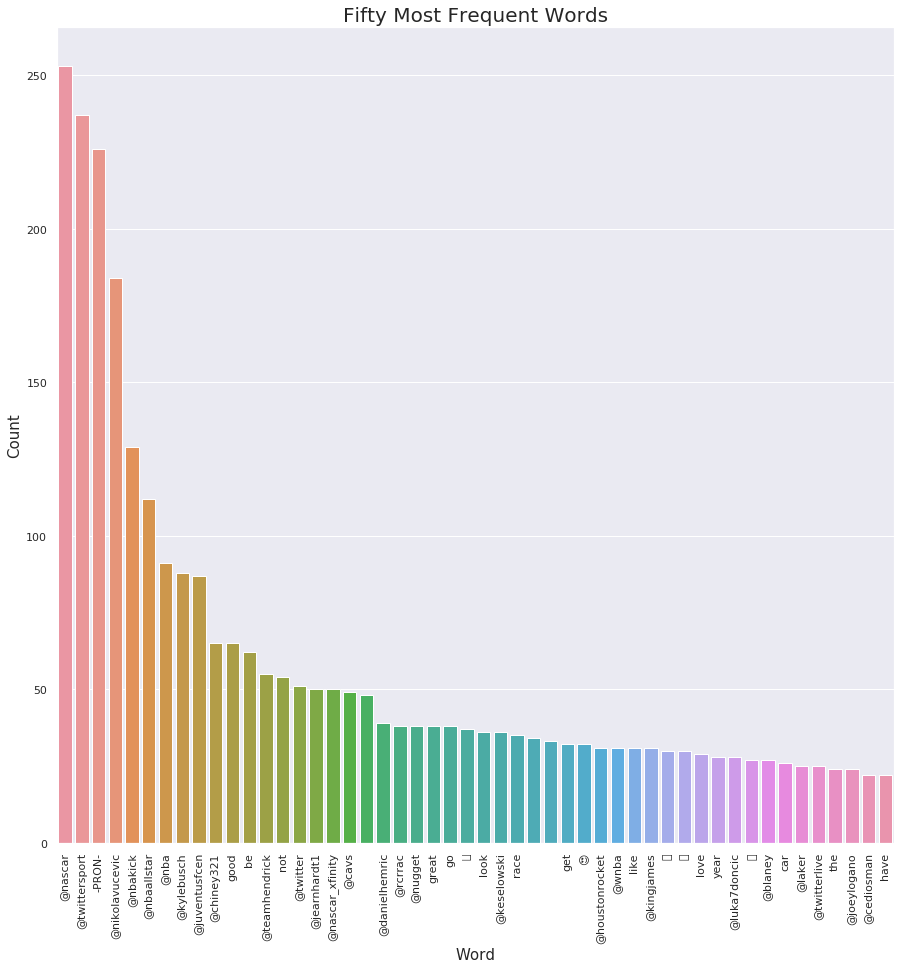

In [62]:
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={"figure.figsize": (15,15)})
ax = sns.barplot(x=total_word_counts["word"][:50], y=total_word_counts["count"][:50], data=total_word_counts)
ax.set_xticklabels(total_word_counts["word"][:50], rotation=90)
ax.set_title("Fifty Most Frequent Words", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)

#### Aggregate BOW data by tweet

In [63]:
len(word_counts["To_Tweet_ID"].unique())

85

In [64]:
aggregated_word_counts = pd.DataFrame(columns=common_frequent_words)

for i, ID in enumerate(word_counts["To_Tweet_ID"].unique()):
    indices = list(np.where(word_counts["To_Tweet_ID"] == ID)[0])
    sums = word_counts.iloc[indices].sum()
    aggregated_word_counts.loc[i] = sums

aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

In [65]:
aggregated_word_counts.shape

(85, 1083)

In [66]:
aggregated_word_counts.head()

lebrons perform go bai @austindillon3 have @antdavis23 partner house woman  \
0       0       0  0   0              0    0           0       0     0     0   
1       0       0  0   0              0    0           0       0     0     0   
2       0       0  0   0              0    0           0       0     0     0   
3       0       0  0   0              0    0           0       0     0     0   
4       0       0  0   0              0    0           0       0     0     0   

          ...          teamgiannis cringe wear ils speed  \
0         ...                    0      0    0   1     0   
1         ...                    0      0    0   0     0   
2         ...                    0      0    0   0     0   
3         ...                    0      0    0   0     0   
4         ...                    0      0    0   0     0   

  https://t.co/oy1y8vtn3w that real @dennyhamlin          To_Tweet_ID  
0                       0    0    0            0  1098235335132303362  
1                       0    0    0            0  1097537733155786753  
2                       0    0    0            0  1097532955533160448  
3                       0    0    0            0  1097517678200270849  
4                       0    0    0            0  1097498653986603008  

[5 rows x 1083 columns]

In [67]:
aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

### Preparing the Data for Modeling

**BOW Features**

In [68]:
aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

In [69]:
#adding a percent_likes column to the aggregated BOW dataframe because that is the value I am predicting

aggregated_word_counts["Total_Followers"] = None
aggregated_word_counts["Num_Likes"] = None
aggregated_word_counts["Percent_Likes"] = None
aggregated_word_counts.head()

lebrons perform go bai @austindillon3 have @antdavis23 partner house woman  \
0       0       0  0   0              0    0           0       0     0     0   
1       0       0  0   0              0    0           0       0     0     0   
2       0       0  0   0              0    0           0       0     0     0   
3       0       0  0   0              0    0           0       0     0     0   
4       0       0  0   0              0    0           0       0     0     0   

       ...      ils speed https://t.co/oy1y8vtn3w that real @dennyhamlin  \
0      ...        1     0                       0    0    0            0   
1      ...        0     0                       0    0    0            0   
2      ...        0     0                       0    0    0            0   
3      ...        0     0                       0    0    0            0   
4      ...        0     0                       0    0    0            0   

           To_Tweet_ID Total_Followers Num_Likes Percent_Likes  
0  1098235335132303362            None      None          None  
1  1097537733155786753            None      None          None  
2  1097532955533160448            None      None          None  
3  1097517678200270849            None      None          None  
4  1097498653986603008            None      None          None  

[5 rows x 1086 columns]

In [70]:
aggregated_word_counts.shape

(85, 1086)

In [71]:
#bringing in number of likes, followers, and percent_liked

likes_list = []

for i in range(aggregated_word_counts.shape[0]):
    ID = aggregated_word_counts["To_Tweet_ID"].iloc[i]
    if ID in list(FTM_df["Tweet_ID"]):
        n = np.where(FTM_df["Tweet_ID"] == ID)
        likes_list.append(FTM_df.iloc[int(n[0]), 1])
    elif ID in list(Gen_df["Tweet_ID"]):
        n = np.where(Gen_df["Tweet_ID"] == ID)
        likes_list.append(Gen_df.iloc[int(n[0]), 4])
    else:
        likes_list.append("Not found")
        
aggregated_word_counts["Num_Likes"] = likes_list

In [72]:
aggregated_word_counts.head()

lebrons perform go bai @austindillon3 have @antdavis23 partner house woman  \
0       0       0  0   0              0    0           0       0     0     0   
1       0       0  0   0              0    0           0       0     0     0   
2       0       0  0   0              0    0           0       0     0     0   
3       0       0  0   0              0    0           0       0     0     0   
4       0       0  0   0              0    0           0       0     0     0   

       ...      ils speed https://t.co/oy1y8vtn3w that real @dennyhamlin  \
0      ...        1     0                       0    0    0            0   
1      ...        0     0                       0    0    0            0   
2      ...        0     0                       0    0    0            0   
3      ...        0     0                       0    0    0            0   
4      ...        0     0                       0    0    0            0   

           To_Tweet_ID Total_Followers Num_Likes Percent_Likes  
0  1098235335132303362            None       193          None  
1  1097537733155786753            None      1582          None  
2  1097532955533160448            None       916          None  
3  1097517678200270849            None       972          None  
4  1097498653986603008            None       966          None  

[5 rows x 1086 columns]

In [73]:
followers_list = []

for i in range(aggregated_word_counts.shape[0]):
    ID = aggregated_word_counts["To_Tweet_ID"].iloc[i]
    if ID in list(FTM_df["Tweet_ID"]):
        n = np.where(FTM_df["Tweet_ID"] == ID)
        followers_list.append(FTM_df.iloc[int(n[0]), 3])
    elif ID in list(Gen_df["Tweet_ID"]):
        n = np.where(Gen_df["Tweet_ID"] == ID)
        followers_list.append(Gen_df.iloc[int(n[0]), 1])
    else:
        followers_list.append("Not found")
        
aggregated_word_counts["Total_Followers"] = followers_list
    
    

        
    

In [74]:
aggregated_word_counts.head()

lebrons perform go bai @austindillon3 have @antdavis23 partner house woman  \
0       0       0  0   0              0    0           0       0     0     0   
1       0       0  0   0              0    0           0       0     0     0   
2       0       0  0   0              0    0           0       0     0     0   
3       0       0  0   0              0    0           0       0     0     0   
4       0       0  0   0              0    0           0       0     0     0   

       ...      ils speed https://t.co/oy1y8vtn3w that real @dennyhamlin  \
0      ...        1     0                       0    0    0            0   
1      ...        0     0                       0    0    0            0   
2      ...        0     0                       0    0    0            0   
3      ...        0     0                       0    0    0            0   
4      ...        0     0                       0    0    0            0   

           To_Tweet_ID Total_Followers Num_Likes Percent_Likes  
0  1098235335132303362           72400       193          None  
1  1097537733155786753           17800      1582          None  
2  1097532955533160448           17800       916          None  
3  1097517678200270849           17800       972          None  
4  1097498653986603008           17800       966          None  

[5 rows x 1086 columns]

In [75]:
aggregated_word_counts["Percent_Likes"] = aggregated_word_counts["Num_Likes"] / aggregated_word_counts["Total_Followers"]


In [76]:
aggregated_word_counts.head()

lebrons perform go bai @austindillon3 have @antdavis23 partner house woman  \
0       0       0  0   0              0    0           0       0     0     0   
1       0       0  0   0              0    0           0       0     0     0   
2       0       0  0   0              0    0           0       0     0     0   
3       0       0  0   0              0    0           0       0     0     0   
4       0       0  0   0              0    0           0       0     0     0   

       ...      ils speed https://t.co/oy1y8vtn3w that real @dennyhamlin  \
0      ...        1     0                       0    0    0            0   
1      ...        0     0                       0    0    0            0   
2      ...        0     0                       0    0    0            0   
3      ...        0     0                       0    0    0            0   
4      ...        0     0                       0    0    0            0   

           To_Tweet_ID Total_Followers Num_Likes Percent_Likes  
0  1098235335132303362           72400       193      0.002666  
1  1097537733155786753           17800      1582      0.088876  
2  1097532955533160448           17800       916      0.051461  
3  1097517678200270849           17800       972      0.054607  
4  1097498653986603008           17800       966      0.054270  

[5 rows x 1086 columns]

In [77]:
aggregated_word_counts = aggregated_word_counts.fillna(0)


In [78]:
#setting up training and test sets for both dataframes (word counts and word vectors)
offset_c = int(aggregated_word_counts.shape[0] / 2)
df_train_counts = aggregated_word_counts.iloc[:offset_c]
df_test_counts = aggregated_word_counts.iloc[offset_c:]

xc_train, yc_train = df_train_counts.loc[:, ~df_train_counts.columns.isin(["To_Tweet_ID", "Total_Followers", 
                                                       "Num_Likes", "Percent_Likes"])], df_train_counts["Percent_Likes"]
xc_test, yc_test = df_test_counts.loc[:, ~df_test_counts.columns.isin(["To_Tweet_ID", "Total_Followers", 
                                                       "Num_Likes", "Percent_Likes"])], df_test_counts["Percent_Likes"]


### Running word counts and word vectors through multiple supervised learning models

In [79]:
#KNN Regression

#word counts
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neighbors = KNeighborsRegressor(n_neighbors=10, weights="distance")
neighbors.fit(xc_train, yc_train)
yc_pred_train = neighbors.predict(xc_train)

print("KNN Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = neighbors.predict(xc_test)

print("\nKNN Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))


KNN Train Word Counts: MAE, MSE, RMSE
0.0
0.0
0.0

KNN Test Word Counts: MAE, MSE, RMSE
0.024038046077317996
0.0008329035052508493
0.028860067658459315


In [80]:
#Linear regression
from sklearn.linear_model import LinearRegression

#word counts
linear = LinearRegression(fit_intercept=True)
linear.fit(xc_train, yc_train)
yc_pred_train = linear.predict(xc_train)

print("Linear Regression Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = linear.predict(xc_test)

print("\nLinear Regression Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))




Linear Regression Train Word Counts: MAE, MSE, RMSE
1.7377513162514744e-16
1.128003326043256e-31
3.358576076320523e-16

Linear Regression Test Word Counts: MAE, MSE, RMSE
0.04967783683748345
0.013285807422477177
0.11526407689508981


In [81]:
# Random Forest

#word counts
from sklearn import ensemble

rfc = ensemble.RandomForestRegressor()

rfc.fit(xc_train, yc_train)
yc_pred_train = rfc.predict(xc_train)

print("Random Forest Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = rfc.predict(xc_test)

print("\nRandom Forest Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))


Random Forest Train Word Counts: MAE, MSE, RMSE
0.004677596504118781
7.596821357186717e-05
0.008715974619735143

Random Forest Test Word Counts: MAE, MSE, RMSE
0.01005148526344138
0.000564280991789516
0.02375459938179375


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Percent_Like as A Classification Problem

After running various supervised learning models on the bag of words data as a regression model, the results were inconsistent and had high mean average errors (MAE). As such, I decided to change the problem into a classification problem. Because of the range in percent likes, I classified all tweets below the median percent likes as "Below Average," all tweets between the median and the mean as "Average," and all tweets above the mean of percent likes as "Above Average."

Now that I had a classification problem on my hands, I tried fitting and predicting the data with a decision tree, logistic regression (both lasso and ridge regression), a KNN classifier, and a Random Forest classifier.

**Decision Trees**

In [82]:
yc_test_class = []

for y in yc_test:
    if y < yc_test.median():
        yc_test_class.append("Below_Average")
    elif (y > yc_test.median()) and (y < yc_test.mean()):
        yc_test_class.append("Average")
    elif y > yc_test.mean():
        yc_test_class.append("Above_Average")
    else:
        yc_test_class.append("Average")
        
yc_train_class = []

for y in yc_train:
    if y < yc_train.median():
        yc_train_class.append("Below_Average")
    elif (y > yc_train.median()) and (y < yc_train.mean()):
        yc_train_class.append("Average")
    elif y > yc_train.mean():
        yc_train_class.append("Above_Average")
    else:
        yc_train_class.append("Average")
        

In [91]:
#KNN Classifier 

#word counts
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

neighbors = KNeighborsClassifier(n_neighbors=7, weights="distance")
neighbors.fit(xc_train, yc_train_class)
yc_pred_train = neighbors.predict(xc_train)


yc_pred_test = neighbors.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training KNN Classifier:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test KNN Classifier:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training KNN Classifier: 1.0
Percent Accuracy of Test KNN Classifier: 0.4186046511627907


In [92]:
#Logistic regression - Ridge regression

from sklearn.linear_model import LogisticRegression

#word counts
logist = LogisticRegression(penalty="l2", fit_intercept=True)
logist.fit(xc_train, yc_train_class)
yc_pred_train = logist.predict(xc_train)

yc_pred_test = logist.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Logistic (ridge) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (ridge) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Logistic (ridge) Regression: 1.0
Percent Accuracy of Test Logistic (ridge) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [93]:
#Logistic regression - Lasso regression

from sklearn.linear_model import LogisticRegression

#word counts
logist = LogisticRegression(penalty="l1", fit_intercept=True)
logist.fit(xc_train, yc_train_class)
yc_pred_train = logist.predict(xc_train)

yc_pred_test = logist.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [94]:
# Random Forest

#word counts
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc.fit(xc_train, yc_train_class)
yc_pred_train = rfc.predict(xc_train)
yc_pred_test = rfc.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Random Forest:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Random Forest:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Random Forest: 1.0
Percent Accuracy of Test Random Forest: 0.4418604651162791


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Tuning Logistic Regression (Lasso)

The model that had the best outcomes when predicting class and avoided overfitting was logistic (lasso) regression. Below, I try tuning the hyperparameters of that model to optimize the predictive power of the model.

In [95]:
#Tuning hyperparameters Logistic (Lasso) Regression


#word counts
lambdas = [.02, .05, .10, .15, .25, .35, .5, .55, .65, .75, .95, 1, 1.1, 1.3]


for lam in lambdas:
    lass = LogisticRegression(C=1/lam, fit_intercept=True, penalty="l1")
    lass.fit(xc_train, yc_train_class)
    yc_pred_train = lass.predict(xc_train)
    yc_pred_test = lass.predict(xc_test)

    print("Word Counts: ", lam)
    print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
    print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))

    

Word Counts:  0.02
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.05
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325
Word Counts:  0.1
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.15
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.25
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.35
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.4883720930232558
Word Counts:  0.5
Percent Accuracy of Training Logistic (lasso) Regression: 1

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-package

In [96]:
#using optimized logistic (lasso) regression on word counts

lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

print("Word Counts: ", lam)
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:  1.3
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 1.0, 'Cross-tabulation of Logistic (Lasso) Regression Accuracy')

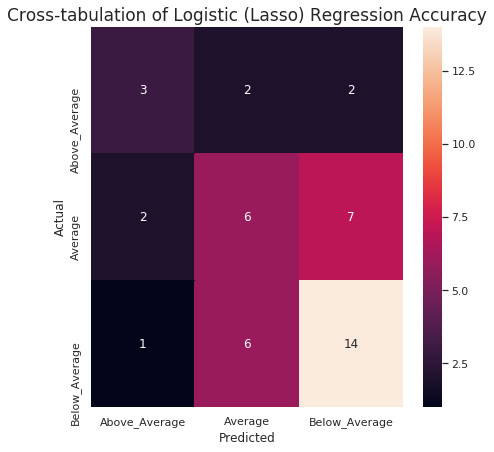

In [97]:
Lassodf = pd.DataFrame()

Lassodf["Actual"] = yc_test_class
Lassodf["Predicted"] = yc_pred_test

sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(Lassodf["Actual"], Lassodf["Predicted"]), annot=True)
ax.set_title("Cross-tabulation of Logistic (Lasso) Regression Accuracy", size=17)

## Clustering

After landing on logistic (lasso) regression as the classifying model with the most predictive power, I wanted to see how looking at the problem as an unsupervised problem might improve results. As you'll see below, all three types of clustering that I try (k-means, meanshift, spectral) got poor predictive classification results.

In [98]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering


In [99]:
cluster_labels = pd.DataFrame()

In [100]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(xc_train)
kmlabels = kmeans.labels_
cluster_labels["KMeans"] = kmlabels

In [101]:
#meanshift

bandwidth = estimate_bandwidth(xc_train, quantile=.5)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit(xc_train)
mslabels = ms.labels_
cluster_labels["Meanshift"] = mslabels

In [102]:
#spectral clustering
sc3 = SpectralClustering(n_clusters=3)
sc3 = sc3.fit(xc_train)
sc3labels = sc3.labels_
cluster_labels["Spectral"] = sc3labels

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  n_init=n_init)


In [103]:
cluster_labels["Actual"] = yc_train_class

In [104]:
cluster_labels.head()

KMeans  Meanshift  Spectral         Actual
0       0          0         2        Average
1       0          0         2  Above_Average
2       0          0         2  Above_Average
3       0          0         2  Above_Average
4       0          0         2  Above_Average

Text(0.5, 1.0, 'Cross-tabulation of K-Means Clustering')

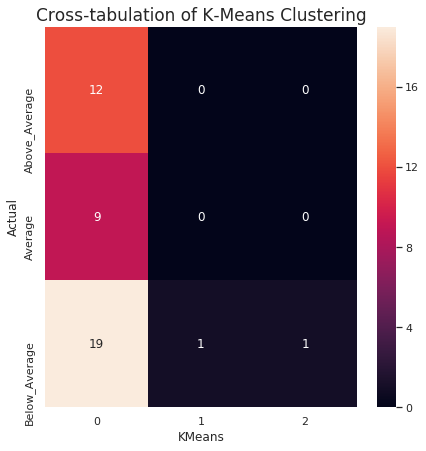

In [105]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["KMeans"]), annot=True)
ax.set_title("Cross-tabulation of K-Means Clustering", size=17)

Text(0.5, 1.0, 'Cross-tabulation of Spectral Clustering')

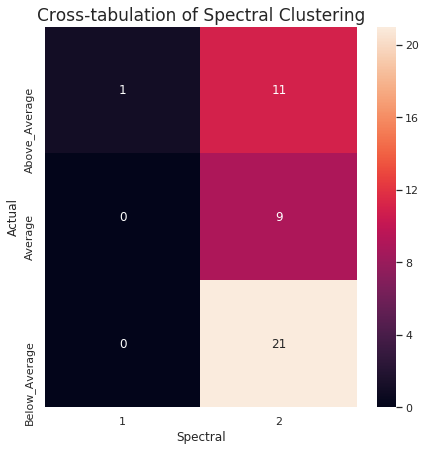

In [106]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["Spectral"]), annot=True)
ax.set_title("Cross-tabulation of Spectral Clustering", size=17)

Text(0.5, 1.0, 'Cross-tabulation of Meanshift Clustering')

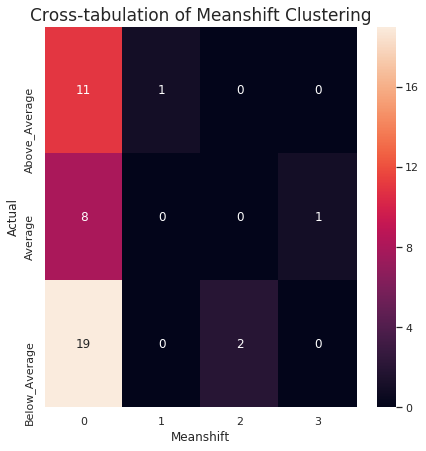

In [107]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["Meanshift"]), annot=True)
ax.set_title("Cross-tabulation of Meanshift Clustering", size=17)

## Exploring Explanatory Power of Logistic (Lasso) Regression

After scraping the data, feature engineering based on bag of words, landing on logistic (lasso) regression as the model with the best predictive power, I wanted to look at feature importance within the model's prediction. In doing so, I could deliver to FTM words/features to aim for in their content and words/features to avoid.

After running all the data through logistic regression, I was able to pull out the users that had the biggest positive impact on the percent likes and those that had the most significant negative impact. While this information might be slightly useful to people advertising on Twitter, I wanted to hone in on just the words/content of the comment instead of who made the users.

However, when I removed the users from the dataset, the predictive accuracy dropped from 55% to 48%. By looking at the data for misclassified tweets (both within the constructs of the dataframe and through data visualizations), I made a few changes to the data that I was feeding into the model. Here were the adjustments I made:
1. Removing pronouns (misclassified tweets had a higher percentage of pronouns that correctly classified tweets)
2. Removing more generic words like "good" and "great" (appeared to skew the prediction)
3. Normalizing the data (tweets with more replies had much higher word counts that were affecting the results)
4. Limiting the number of features to the 10 with the highest count (again, tweets with many replies and a low percent likes were misclassified)

Each time I made an adjustment, I ran the adjusted data through the tuned logistic regression model. The adjustment that had the biggest impact on the predictive power of the model was the fourth one, where I included only the 10 features with the highest word counts and zeroed out the rest. This brought the predictive accuracy to 53.5%. Finally, I re-tuned the hyperparameters of the logistic regression model, which resulted in a predictive accuracy of 55% on the test set.

One important limitation of the model's predictive accuracy is the following:
+ A tweet that is actually below average and has more than 7 features will be misclassified as higher performing

In [108]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

weights = lass.coef_

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [109]:
weights = weights * 100000000

In [110]:
weightsdf = pd.DataFrame(weights, columns=xc_test.columns)

In [111]:
weightsdf

lebrons  perform   go  bai  @austindillon3  have  @antdavis23  partner  \
0      0.0      0.0  0.0  0.0    1.269029e+07   0.0          0.0      0.0   
1      0.0      0.0  0.0  0.0    0.000000e+00   0.0          0.0      0.0   
2      0.0      0.0  0.0  0.0   -2.208044e+06   0.0          0.0      0.0   

   house  woman      ...           @atlhawk  teamgiannis  cringe  wear  ils  \
0    0.0    0.0      ...       0.000000e+00          0.0     0.0   0.0  0.0   
1    0.0    0.0      ...      -2.068663e+07          0.0     0.0   0.0  0.0   
2    0.0    0.0      ...       2.489875e+07          0.0     0.0   0.0  0.0   

   speed  https://t.co/oy1y8vtn3w  that  real  @dennyhamlin  
0    0.0                      0.0   0.0   0.0           0.0  
1    0.0                      0.0   0.0   0.0           0.0  
2    0.0                      0.0   0.0   0.0           0.0  

[3 rows x 1082 columns]

In [112]:
weightsdf = weightsdf.T

weightsdf.head()


0    1             2
lebrons         0.000000e+00  0.0  0.000000e+00
perform         0.000000e+00  0.0  0.000000e+00
go              0.000000e+00  0.0  0.000000e+00
bai             0.000000e+00  0.0  0.000000e+00
@austindillon3  1.269029e+07  0.0 -2.208044e+06

In [113]:
weightsdf.columns = lass.classes_
weightsdf.head()

Above_Average  Average  Below_Average
lebrons          0.000000e+00      0.0   0.000000e+00
perform          0.000000e+00      0.0   0.000000e+00
go               0.000000e+00      0.0   0.000000e+00
bai              0.000000e+00      0.0   0.000000e+00
@austindillon3   1.269029e+07      0.0  -2.208044e+06

In [115]:
#I chose to drop these three features from the model because they were associated with the accounts 
# with the most included tweets; additionally, they have the highest number of followers

xc_test = xc_test.drop(["nba", "nascar", "twitter"], axis=1)

In [116]:
xc_test.shape

(43, 1079)

In [117]:
xc_train = xc_train.drop(["nba", "nascar", "twitter"], axis=1)

In [118]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

weights = lass.coef_

print("Word Counts: ")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Word Counts: 
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325


In [119]:
weights = weights * 100000000

In [120]:
weightsdf = pd.DataFrame(weights, columns=xc_test.columns)

In [121]:
weightsdf

lebrons  perform   go  bai  @austindillon3  have  @antdavis23  partner  \
0      0.0      0.0  0.0  0.0    3.766987e+06   0.0          0.0      0.0   
1      0.0      0.0  0.0  0.0    0.000000e+00   0.0          0.0      0.0   
2      0.0      0.0  0.0  0.0   -3.856526e+06   0.0          0.0      0.0   

   house  woman      ...           @atlhawk  teamgiannis  cringe  wear  ils  \
0    0.0    0.0      ...       0.000000e+00          0.0     0.0   0.0  0.0   
1    0.0    0.0      ...      -2.068223e+07          0.0     0.0   0.0  0.0   
2    0.0    0.0      ...       2.489875e+07          0.0     0.0   0.0  0.0   

   speed  https://t.co/oy1y8vtn3w  that  real  @dennyhamlin  
0    0.0                      0.0   0.0   0.0           0.0  
1    0.0                      0.0   0.0   0.0           0.0  
2    0.0                      0.0   0.0   0.0           0.0  

[3 rows x 1079 columns]

In [122]:
weightsdf = weightsdf.T

weightsdf.head()


0    1             2
lebrons         0.000000e+00  0.0  0.000000e+00
perform         0.000000e+00  0.0  0.000000e+00
go              0.000000e+00  0.0  0.000000e+00
bai             0.000000e+00  0.0  0.000000e+00
@austindillon3  3.766987e+06  0.0 -3.856526e+06

In [123]:
weightsdf.columns = lass.classes_
weightsdf.head()

Above_Average  Average  Below_Average
lebrons          0.000000e+00      0.0   0.000000e+00
perform          0.000000e+00      0.0   0.000000e+00
go               0.000000e+00      0.0   0.000000e+00
bai              0.000000e+00      0.0   0.000000e+00
@austindillon3   3.766987e+06      0.0  -3.856526e+06

In [124]:
above_average = weightsdf[weightsdf["Above_Average"] != 0]
above_average

Above_Average       Average  Below_Average
@austindillon3   3.766987e+06  0.000000e+00  -3.856526e+06
@tylerreddick    2.563613e+07  0.000000e+00  -1.936661e+07
@chiney321      -1.221217e+07  0.000000e+00   8.046925e+07
@twittersport   -2.024809e+07 -5.099938e+07   5.465042e+07
@mac11          -7.887607e+07  7.632729e+07   0.000000e+00
@teamhendrick   -3.763639e+06  1.893108e+07  -1.525735e+07
@rcrrac          8.707371e+06  0.000000e+00  -8.136113e+06
@nba             1.345648e+08 -6.755561e+07   0.000000e+00
@nascar         -3.000726e+07 -6.081033e+07   5.376213e+07
¬¥                2.032305e+06 -2.199247e+06   0.000000e+00
@kylekuzma       5.502387e+07 -2.897741e+06   0.000000e+00
@nikolavucevic  -6.129297e+06  3.030256e+07  -2.610501e+07
@danielhemric    3.859494e+06  0.000000e+00  -5.673567e+06
@nbakick         4.596178e+06 -9.926765e+06  -1.015362e+08
@luka7doncic     2.229051e+07  0.000000e+00   0.000000e+00
@wnba           -1.491702e+07  0.000000e+00   0.000000e+00

In [125]:
def influence_type(score):
    if score > 0:
        return 1
    else: 
        return 0

above_average["Positive_Influence"] = above_average["Above_Average"].apply(influence_type)

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [126]:
above_average

Above_Average       Average  Below_Average  Positive_Influence
@austindillon3   3.766987e+06  0.000000e+00  -3.856526e+06                   1
@tylerreddick    2.563613e+07  0.000000e+00  -1.936661e+07                   1
@chiney321      -1.221217e+07  0.000000e+00   8.046925e+07                   0
@twittersport   -2.024809e+07 -5.099938e+07   5.465042e+07                   0
@mac11          -7.887607e+07  7.632729e+07   0.000000e+00                   0
@teamhendrick   -3.763639e+06  1.893108e+07  -1.525735e+07                   0
@rcrrac          8.707371e+06  0.000000e+00  -8.136113e+06                   1
@nba             1.345648e+08 -6.755561e+07   0.000000e+00                   1
@nascar         -3.000726e+07 -6.081033e+07   5.376213e+07                   0
¬¥                2.032305e+06 -2.199247e+06   0.000000e+00                   1
@kylekuzma       5.502387e+07 -2.897741e+06   0.000000e+00                   1
@nikolavucevic  -6.129297e+06  3.030256e+07  -2.610501e+07                   0
@danielhemric    3.859494e+06  0.000000e+00  -5.673567e+06                   1
@nbakick         4.596178e+06 -9.926765e+06  -1.015362e+08                   1
@luka7doncic     2.229051e+07  0.000000e+00   0.000000e+00                   1
@wnba           -1.491702e+07  0.000000e+00   0.000000e+00                   0

In [127]:
positive_important_features = list(above_average[above_average["Positive_Influence"] == 1].index)
negative_important_features = list(above_average[above_average["Positive_Influence"] == 0].index)

In [128]:
#most important users for above average percent likes

print("Most important USERS that POSITIVELY influence an above average tweet: ", positive_important_features)
print("Most important USERS that NEGATIVELY influence an above average tweet: ", negative_important_features)


Most important USERS that POSITIVELY influence an above average tweet:  ['@austindillon3', '@tylerreddick', '@rcrrac', '@nba', '¬¥', '@kylekuzma', '@danielhemric', '@nbakick', '@luka7doncic']
Most important USERS that NEGATIVELY influence an above average tweet:  ['@chiney321', '@twittersport', '@mac11', '@teamhendrick', '@nascar', '@nikolavucevic', '@wnba']


In [129]:
drop_users = []

for feature in xc_train.columns:
    if "@" in feature:
        drop_users.append(feature)

In [130]:
xc_train = xc_train.drop(drop_users, axis=1)

In [131]:
xc_test = xc_test.drop(drop_users, axis=1)

In [132]:
xc_test.shape

(43, 968)

In [133]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

weights = lass.coef_

print("Word Counts: ")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts: 
Percent Accuracy of Training Logistic (lasso) Regression: 0.8571428571428571
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [217]:
# including only the top 10 most used words in a tweet and zeroing out the rest
xc_train_zeroed = xc_train

for i in range(xc_train.shape[0]):
    ordered = xc_train_zeroed.iloc[i, :].sort_values()
    ordered.iloc[-955:-1] = 0
    ordered = ordered.sort_index()
    xc_train_zeroed.iloc[i, :] = ordered
    
xc_test_zeroed = xc_test

for i in range(xc_test.shape[0]):
    ordered = xc_test_zeroed.iloc[i, :].sort_values()
    ordered.iloc[-955:-1] = 0
    ordered = ordered.sort_index()
    xc_test_zeroed.iloc[i, :] = ordered

In [218]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train_zeroed, yc_train_class)
yc_pred_train = lass.predict(xc_train_zeroed)
yc_pred_test = lass.predict(xc_test_zeroed)

weights = lass.coef_

print("Word Counts: ")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts: 
Percent Accuracy of Training Logistic (lasso) Regression: 0.8333333333333334
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [229]:
#re-tuning the hyperparameters of the model based on the zeroed out data
lambdas = [.02, .05, .10, .15, .25, .35, .5, .55, .65, .75, .95, 1, 1.1, 1.3]


for lam in lambdas:
    lass = LogisticRegression(C=1/lam, fit_intercept=True, penalty="l1")
    lass.fit(xc_train_zeroed, yc_train_class)
    yc_pred_train = lass.predict(xc_train_zeroed)
    yc_pred_test = lass.predict(xc_test_zeroed)

    print("Word Counts: ", lam)
    print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
    print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:  0.02
Percent Accuracy of Training Logistic (lasso) Regression: 0.9523809523809523
Percent Accuracy of Test Logistic (lasso) Regression: 0.46511627906976744
Word Counts:  0.05
Percent Accuracy of Training Logistic (lasso) Regression: 0.9523809523809523
Percent Accuracy of Test Logistic (lasso) Regression: 0.46511627906976744
Word Counts:  0.1
Percent Accuracy of Training Logistic (lasso) Regression: 0.9285714285714286
Percent Accuracy of Test Logistic (lasso) Regression: 0.46511627906976744
Word Counts:  0.15
Percent Accuracy of Training Logistic (lasso) Regression: 0.9285714285714286
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.25
Percent Accuracy of Training Logistic (lasso) Regression: 0.9285714285714286
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.35
Percent Accuracy of Training Logistic (lasso) Regression: 0.9285714285714286
Percent Accuracy of Test Logistic (lasso) Regression: 0.5

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-package

In [230]:
lass = LogisticRegression(C=1/.5, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train_zeroed, yc_train_class)
yc_pred_train = lass.predict(xc_train_zeroed)
yc_pred_test = lass.predict(xc_test_zeroed)

weights = lass.coef_

print("Word Counts: ")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts: 
Percent Accuracy of Training Logistic (lasso) Regression: 0.9285714285714286
Percent Accuracy of Test Logistic (lasso) Regression: 0.5581395348837209


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [231]:
weights = weights * 100000000

In [232]:
weightsdf = pd.DataFrame(weights, columns=xc_test.columns)

In [233]:
weightsdf

lebrons  perform            go  bai  have  partner  house  woman  sont  \
0      0.0      0.0  0.000000e+00  0.0   0.0      0.0    0.0    0.0   0.0   
1      0.0      0.0  0.000000e+00  0.0   0.0      0.0    0.0    0.0   0.0   
2      0.0      0.0  5.623067e+07  0.0   0.0      0.0    0.0    0.0   0.0   

   snoozerville  ...   coquettish  denver  teamgiannis  cringe  wear  ils  \
0           0.0  ...          0.0     0.0          0.0     0.0   0.0  0.0   
1           0.0  ...          0.0     0.0          0.0     0.0   0.0  0.0   
2           0.0  ...          0.0     0.0          0.0     0.0   0.0  0.0   

   speed  https://t.co/oy1y8vtn3w  that  real  
0    0.0                      0.0   0.0   0.0  
1    0.0                      0.0   0.0   0.0  
2    0.0                      0.0   0.0   0.0  

[3 rows x 965 columns]

In [234]:
weightsdf = weightsdf.T

weightsdf.head()


0    1             2
lebrons  0.0  0.0  0.000000e+00
perform  0.0  0.0  0.000000e+00
go       0.0  0.0  5.623067e+07
bai      0.0  0.0  0.000000e+00
have     0.0  0.0  0.000000e+00

In [235]:
weightsdf.columns = lass.classes_
weightsdf.head()

Above_Average  Average  Below_Average
lebrons            0.0      0.0   0.000000e+00
perform            0.0      0.0   0.000000e+00
go                 0.0      0.0   5.623067e+07
bai                0.0      0.0   0.000000e+00
have               0.0      0.0   0.000000e+00

In [236]:
above_average = weightsdf[weightsdf["Above_Average"] != 0]
above_average

Above_Average       Average  Below_Average
fan                      -1.041383e+07 -2.864091e+06   4.039827e+07
üëé                        -8.483188e+06  0.000000e+00   4.446451e+07
need                      1.127501e+08  0.000000e+00  -5.278122e+07
not                      -2.082767e+07 -5.728181e+06   8.079654e+07
üî¥                         1.127501e+08  0.000000e+00  -5.279032e+07
üèÄ                        -6.968999e+06  0.000000e+00   8.842696e+07
üá∫                         5.601394e+07 -6.025005e+06  -3.352561e+07
nbatwitter               -1.112162e+07 -7.637123e+06   2.496059e+07
jimmie                   -1.041383e+07 -2.864091e+06   4.039827e+07
¬¥                         9.297438e+07  0.000000e+00  -4.799773e+07
üëç                        -1.042025e+07  7.706575e+07  -3.953157e+07
üôå                        -8.483188e+06  0.000000e+00   4.446451e+07
https://t.co/q5ho4zkx2o   1.773065e+08  0.000000e+00   0.000000e+00
Ô∏è                         1.127501e+08  0.000000e+00  -5.278123e+07
soo                       1.773065e+08  0.000000e+00   0.000000e+00
look                     -1.232399e+07 -7.249811e+05   1.685450e+07
‚ù§                         1.127501e+08  0.000000e+00  -5.278122e+07
race                     -8.483188e+06  0.000000e+00   4.446451e+07
luck                      1.309004e+07  4.187340e+07  -5.428501e+07
üêç                         7.939810e+07  0.000000e+00  -4.342447e+07
ÏπòÏπòÏπòÏπò                      1.773065e+08  0.000000e+00   0.000000e+00
üî•                         3.805814e+07  3.063060e+07  -5.908824e+07

In [237]:
def influence_type(score):
    if score > 0:
        return 1
    else: 
        return 0

above_average["Positive_Influence"] = above_average["Above_Average"].apply(influence_type)

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [238]:
positive_important_features = list(above_average[above_average["Positive_Influence"] == 1].index)
negative_important_features = list(above_average[above_average["Positive_Influence"] == 0].index)

In [239]:
#most important users for above average percent likes
#results
print("Most important POSITIVE features of an above average tweet: ", positive_important_features)
print("Most important NEGATIVE features of an above average tweet: ", negative_important_features)


Most important POSITIVE features of an above average tweet:  ['need', 'üî¥', 'üá∫', '¬¥', 'https://t.co/q5ho4zkx2o', 'Ô∏è', 'soo', '‚ù§', 'luck', 'üêç', 'ÏπòÏπòÏπòÏπò', 'üî•']
Most important NEGATIVE features of an above average tweet:  ['fan', 'üëé', 'not', 'üèÄ', 'nbatwitter', 'jimmie', 'üëç', 'üôå', 'look', 'race']
